In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

In [23]:
df_train = pd.read_csv('/kaggle/input/sentiment-analyst/train_data_single/part-00000-abd2d631-00fd-4975-a058-ffbd706f7bcb-c000.csv')
df_val = pd.read_csv('/kaggle/input/sentiment-analyst/val_data_single/part-00000-8cc101df-e287-47d4-aa3d-6fbe733328ad-c000.csv')

In [24]:
# Combine both datasets, ensuring all columns are included
df = pd.concat([df_train, df_val], axis=0, ignore_index=True)

In [25]:
df.sample(7)

,text,sentiment,processed_text,words,processed_words
10999,all my pancakes always end up soggy.,2,pancakes always end soggy,all my pancakes always end up soggy,pancakes always end soggy
18019,is wishing work was done soon <3,1,wishing work done soon,is wishing work was done soon,wishing work done soon
6378,you don`t love me anymore!,2,love anymore,you don t love me anymore,love anymore
8475,And now im all hungry and thirsty. and too afr...,2,im hungry thirsty afraid go downstairs,and now im all hungry and thirsty and too afr...,im hungry thirsty afraid go downstairs
16885,"So happy. Great, glowy, ravey, beery night. No...",1,happy great glowy ravey beery night smokey pi...,so happy great glowy ravey beery night no...,happy great glowy ravey beery night smokey pi...
11177,errr....I don`t want to go sit in the heat and...,2,errr want go sit heat watch high school gradu...,errr i don t want to go sit in the heat and...,errr want go sit heat watch high school gradu...
13305,"If I am... so are U, my friend. HA! But the ...",1,u friend ha thing make old look good,if i am so are u my friend ha but the ...,u friend ha thing make old look good


In [26]:
print(f'The shape of the dataset is : {df.shape}')
print(f'The columns are :{df.columns}')
print(f'The dtypes of the dataset : \n\n{df.dtypes}')

The shape of the dataset is : (23785, 5)
The columns are :Index(['text', 'sentiment', 'processed_text', 'words', 'processed_words'], dtype='object')
The dtypes of the dataset : 

text               object
sentiment           int64
processed_text     object
words              object
processed_words    object
dtype: object


In [27]:
df.describe(include='all')

,text,sentiment,processed_text,words,processed_words
count,23785,23785.000000,23727,23783,23727
unique,23762,NaN,23274,23591,23274
top,I miss you,NaN,happy mothers day,happy mothers day,happy mothers day
freq,3,NaN,19,17,19
mean,NaN,0.998486,NaN,NaN,NaN
std,NaN,0.816238,NaN,NaN,NaN
min,NaN,0.000000,NaN,NaN,NaN
25%,NaN,0.000000,NaN,NaN,NaN
50%,NaN,1.000000,NaN,NaN,NaN
75%,NaN,2.000000,NaN,NaN,NaN


<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:30px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b> EDA</b></div>

In [28]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [29]:
show_details(df)

,text,sentiment,processed_text,words,processed_words
Missed_Values,0.000000,0.000000,58.000000,2.000000,58.000000
Missed_Values %,0.000000,0.000000,0.002439,0.000084,0.002439
Duplicated values,16.000000,16.000000,16.000000,16.000000,16.000000
Duplicated values %,0.000673,0.000673,0.000673,0.000673,0.000673


In [30]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,text,sentiment,processed_text,words,processed_words
Missed_Values,0.0,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0,0.0


In [31]:
print(f'The unique values of Mode : {len(df.sentiment.unique())}')
print('**' * 20)
print(df.sentiment.unique())

The unique values of Mode : 3
****************************************
[0 2 1]


In [32]:
mode = df.sentiment.value_counts()
mode.to_frame().T

sentiment,1,2,0
count,7927,7898,7886


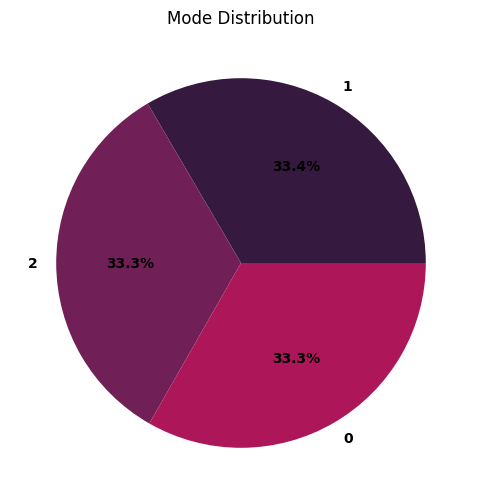

In [33]:
plt.figure(figsize=(6,6))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("rocket"))
plt.title('Mode Distribution') 
plt.show()

In [34]:
def text_cleaner(text):
    
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text


In [35]:
# Tokenizer = TweetTokenizer()
Tokenizer=RegexpTokenizer(r'\w+')

In [36]:
counter_vectorizer = CountVectorizer()

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
TF_IDF = TfidfVectorizer()


In [66]:
stopwords_list = stopwords.words('english')

In [40]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['sentiment']==kind]['text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

In [42]:
# df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
df['text'] = df['text'].apply(lambda x : text_cleaner(x))
df['text']= df['text'].apply(lambda x : Tokenizer.tokenize(x))
df['text'].to_frame()

,text
0,"[go, get, em, lol]"
1,"[i, like, fridays, generally, but, class, is, ..."
2,"[mc, john, si, am, posit, 3, yr, passed, no, s..."
3,"[what, to, say]"
4,"[from, g, s, to, gents, season, 1]"
...,...
23780,"[yaayy, cannot, wait, for, today, girls, gotta..."
23781,"[yay, that, was, good, umm, reggie, perrin, ne..."
23782,"[you, are, so, right]"
23783,"[you, know, what, it, is, to, see, people, you..."


Lemmas and Stems

In [43]:
nlp = spacy.load("en_core_web_sm")


In [44]:
df['text'].sample(10)

1155     [that, will, make, things, fair, my, poor, tig...
2202                                 [that, includes, you]
14531                                 [i, lurveeeeee, you]
15924    [had, a, good, ti, ame, at, flap, a, taco, wit...
18774    [i, know, but, there, are, loads, of, others, ...
14765           [nope, but, the, t1i, looks, super, sweet]
11468    [i, got, in, a, fight, with, ryan, now, hes, l...
12007            [on, my, way, to, work, i, m, so, hungry]
13655                                 [thank, you, sister]
17919                        [pretty, good, friday, night]
Name: text, dtype: object

In [45]:
# lemmatizer = WordNetLemmatizer() 
Stemmer = PorterStemmer()
def stopwords_cleaner(text):
#     word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting
df['text'] = df['text'].apply(lambda x : stopwords_cleaner(x))
# stopwords_cleaner(Tokenizer.tokenize(df.Text[100]))

In [46]:
df['text'][:10].to_frame()

,text
0,go get em lol
1,like friday gener class extend today starv x h...
2,mc john si posit 3 yr pass softe strand withou...
3,say
4,g gent season 1
5,decemb that like year away
6,need wardrob intervent
7,sent donat eric want put banner avatar disappe...
8,tri pincod say expir put
9,point abl involv convo lack iphon


In [47]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, text, sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = self.text[item, :]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.long)
        }

In [48]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

In [49]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

### Architecture du Modèle

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

class sentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_size, num_heads=8):
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embed_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True  # Fine-tune embeddings
        
        # LSTM layer with two layers
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        
        # Multihead Attention layer
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=num_heads, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)  
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*2, output_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        attn_output, _ = self.multihead_attention(lstm_out, lstm_out, lstm_out)
        attn_output = attn_output[:, -1] 
        out = self.dropout(attn_output)  
        out = self.fc(out)
        return out

In [51]:
y = df.sentiment.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

In [52]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3

if torch.cuda.is_available():    
       device = torch.device("cuda")
else:
       device = torch.device("cpu")
print(f'Current device is {device}')


Current device is cuda


In [53]:
# Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.text.values)
xtest = tokenizer.texts_to_sequences(test_df.text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)

# Use the CustomDataset class
train_dataset = CustomDataset(text=xtrain, sentiment=train_df.sentiment.values)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

valid_dataset = CustomDataset(text=xtest, sentiment=test_df.sentiment.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True)

In [54]:
# check a batch of data 
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[  0,   0,   0,  ..., 876, 669,  16],
         [  0,   0,   0,  ..., 358, 817, 138],
         [  0,   0,   0,  ...,  67,  56, 180],
         ...,
         [  0,   0,   0,  ...,  36,  18, 182],
         [  0,   0,   0,  ..., 685, 756, 252],
         [  0,   0,   0,  ...,  24,   7, 228]]),
 'target': tensor([1, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 2,
         1, 2, 2, 2, 2, 1, 2, 2])}

In [55]:
embedding_dict = load_vectors('/kaggle/input/glove6b300dtxt/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)
print(embedding_matrix.shape)

(17908, 300)


In [56]:
model = sentimentBiLSTM(embedding_matrix, hidden_dim=128, output_size=3)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(17908, 300)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (multihead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


In [57]:
import torch
import torch.optim as optim
import numpy as np
import random

# Pour garantir la reproductibilité
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # Si plusieurs GPU
np.random.seed(42)
random.seed(42)

# Définition du dispositif
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimiseur Adam avec amsgrad et scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4, amsgrad=True)

# Scheduler (par exemple MultiStepLR)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6], gamma=0.5)

def acc(pred, label):
    pred = pred.argmax(1)  # Assurez-vous d'obtenir la classe avec la plus haute probabilité
    return torch.sum(pred == label).item()  # Comparez les classes


# Critère
criterion = nn.CrossEntropyLoss()

# Déplacer le modèle sur le bon dispositif (GPU ou CPU)
model = model.to(device)


In [58]:
clip = 5
epochs = 20
valid_loss_min = np.Inf

# Listes pour stocker les résultats
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
    # Entraînement
    train_losses = []
    train_acc = 0.0
    model.train()  # Mode entraînement
    for data in train_loader:  
        inputs = data['text'].to(device, dtype=torch.long)
        labels = data['target'].to(device, dtype=torch.float)

        model.zero_grad()
        output = model(inputs)

        loss = criterion(output, labels.long())
        loss.backward()

        # Clip des gradients pour éviter l'explosion
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_acc += acc(output, labels)

    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)

    # Validation
    val_losses = []
    val_acc = 0.0
    model.eval()  # Mode évaluation
    with torch.no_grad():  # Pas de calcul des gradients pour la validation
        for data in valid_loader:
            inputs = data['text'].to(device, dtype=torch.long)
            labels = data['target'].to(device, dtype=torch.float)

            output = model(inputs)
            val_loss = criterion(output, labels.long())
            val_losses.append(val_loss.item())

            val_acc += acc(output, labels)

    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    # Scheduler (si utilisé)
    # scheduler.step(epoch_val_loss)

    # Enregistrer le meilleur modèle
    if epoch_val_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss}). Saving model...')
        valid_loss_min = epoch_val_loss
        # torch.save(model.state_dict(), 'best_model.pt')

    # Affichage des résultats
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'train_loss: {epoch_train_loss:.4f} val_loss: {epoch_val_loss:.4f}')
    print(f'train_accuracy: {epoch_train_acc*100:.2f}% val_accuracy: {epoch_val_acc*100:.2f}%')
    print("=" * 30)
    
    # Enregistrer les résultats pour chaque époque
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)


Validation loss decreased (inf --> 0.6977259333471995). Saving model...
Epoch 1/20
train_loss: 0.8170 val_loss: 0.6977
train_accuracy: 61.83% val_accuracy: 70.71%
Epoch 2/20
train_loss: 0.5953 val_loss: 0.7244
train_accuracy: 76.31% val_accuracy: 70.46%
Epoch 3/20
train_loss: 0.4352 val_loss: 0.8723
train_accuracy: 83.42% val_accuracy: 68.44%
Epoch 4/20
train_loss: 0.2985 val_loss: 1.0292
train_accuracy: 89.17% val_accuracy: 68.48%
Epoch 5/20
train_loss: 0.2090 val_loss: 1.2721
train_accuracy: 92.72% val_accuracy: 66.69%
Epoch 6/20
train_loss: 0.1968 val_loss: 1.2377
train_accuracy: 93.22% val_accuracy: 66.08%
Epoch 7/20
train_loss: 0.1204 val_loss: 1.5817
train_accuracy: 96.13% val_accuracy: 65.74%
Epoch 8/20
train_loss: 0.0829 val_loss: 1.7936
train_accuracy: 97.28% val_accuracy: 65.61%
Epoch 9/20
train_loss: 0.0697 val_loss: 1.8409
train_accuracy: 97.64% val_accuracy: 64.94%
Epoch 10/20
train_loss: 0.0533 val_loss: 2.2356
train_accuracy: 98.25% val_accuracy: 65.91%
Epoch 11/20
train

In [59]:
torch.save(embedding_matrix, '/kaggle/working/embedding.pt')

In [60]:
print(embedding_matrix.shape)

(17908, 300)


In [61]:
import torch
from collections import defaultdict

# Fonction de tokenisation et de prétraitement de la phrase
def process_text(sentence, word_to_index):
    # Tokenisation simple par espace (à personnaliser selon votre tokenizer)
    tokens = sentence.split()
    
    # Conversion des tokens en indices basés sur le dictionnaire
    indices = [word_to_index.get(token, 0) for token in tokens]  # 0 est la valeur pour les mots inconnus
    
    # Convertir la liste d'indices en tensor PyTorch
    input_tensor = torch.tensor([indices])
    return input_tensor



# Test avec une phrase
def test_model_with_sentence(model, sentence, word_to_index, device):
    model.eval()  # Mettre le modèle en mode évaluation
    input_tensor = process_text(sentence, word_to_index)
    
    # Déplacer l'entrée et le modèle sur le même appareil
    input_tensor = input_tensor.to(device)
    model = model.to(device)
    
    with torch.no_grad():  # Désactiver le calcul des gradients pour la prédiction
        output = model(input_tensor)  # Effectuer la prédiction
    
    # Pour une tâche de classification, obtenir la classe prédite
    _, predicted_class = torch.max(output, dim=1)
    print(f"Phrase: {sentence}\nClasse prédite : {predicted_class.item()}")


# Exemple d'utilisation
if __name__ == "__main__":
    # Vérifiez si un GPU est disponible, sinon utilisez le CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Liste de phrases d'exemple pour créer le vocabulaire
    
    # Créer un modèle (par exemple, une taille de vocabulaire de 10 et une dimension d'embedding de 50)
    
    # Tester le modèle sur une phrase
    sentence = "I think i like this product"
    test_model_with_sentence(model, sentence, tokenizer.word_index, device)


Phrase: I think i like this product
Classe prédite : 2


In [62]:
def plot_weights_and_gradients(model):
    weights, gradients = [], []
    layer_names = []

    for name, param in model.named_parameters():
        if param.requires_grad:  # Considérer uniquement les paramètres entraînables
            layer_names.append(name)
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.cpu().numpy() if param.grad is not None else None)

    num_layers = len(weights)
    fig, axs = plt.subplots(2, num_layers, figsize=(5 * num_layers, 10))  # Taille ajustée

    for i, (w, g) in enumerate(zip(weights, gradients)):
        # Poids
        axs[0, i].hist(w.flatten(), bins=30, color='blue', alpha=0.7)
        axs[0, i].set_title(f'{layer_names[i]} Weights', fontsize=12)
        axs[0, i].set_xlabel('Value', fontsize=10)
        axs[0, i].set_ylabel('Frequency', fontsize=10)

        # Gradients
        if g is not None:
            axs[1, i].hist(g.flatten(), bins=30, color='orange', alpha=0.7)
            axs[1, i].set_title(f'{layer_names[i]} Gradients', fontsize=12)
        else:
            axs[1, i].text(0.5, 0.5, 'No Gradients', fontsize=12, ha='center', va='center')
        axs[1, i].set_xlabel('Value', fontsize=10)
        axs[1, i].set_ylabel('Frequency', fontsize=10)

    plt.tight_layout()
    plt.show()

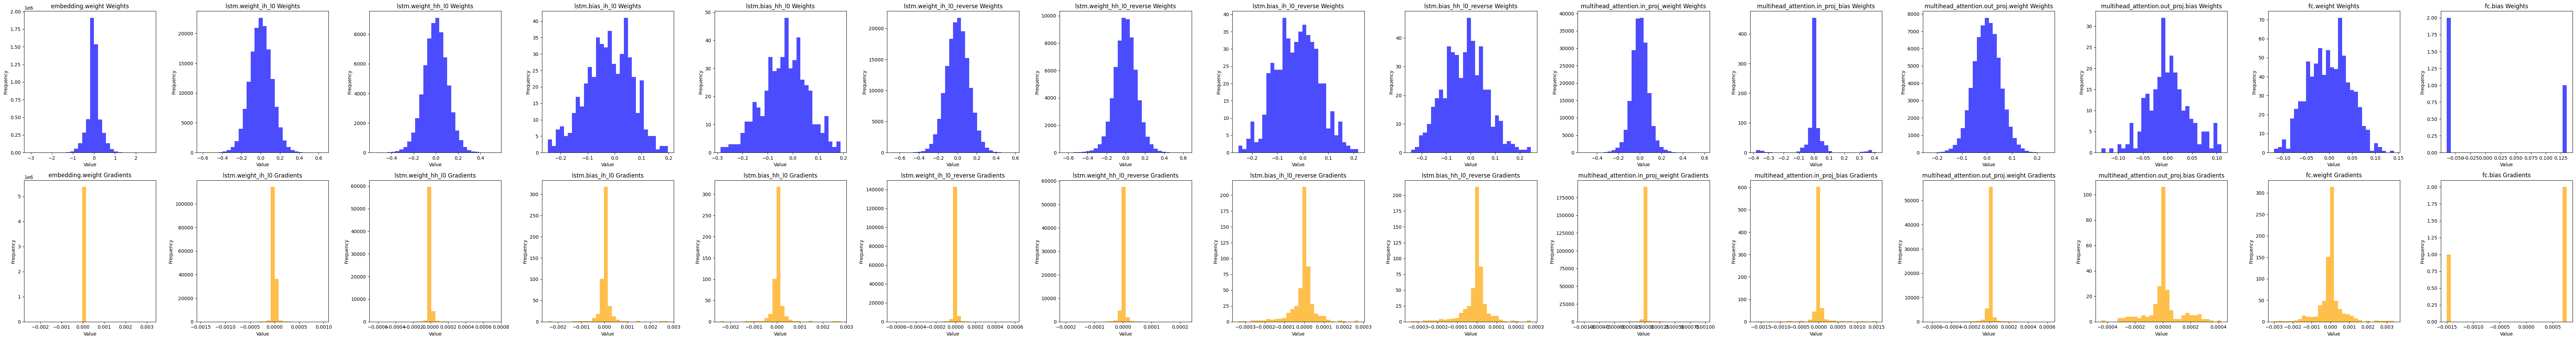

In [63]:
plot_weights_and_gradients(model)

In [64]:
# Supposons que votre modèle s'appelle 'model' (en cours d'entraînement)
torch.save(model.state_dict(), "/kaggle/working/sentiment_modelfinal.pth")
# Exemple de sauvegarde de la matrice d'embedding

In [65]:
import pickle

# Sauvegarder le word_index dans un fichier
with open('word_index.pkl', 'wb') as file:
    pickle.dump(tokenizer.word_index, file)
